In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Unitary Designs
===============

::: {.meta}
:property=\"og:description\": Learn about designs and their uses in
quantum computing.

:property=\"og:image\": <https://pennylane.ai/qml/_images/fano.png>
:::

::: {.related}
tutorial\_haar\_measure Understanding the Haar measure
:::

*Author: PennyLane dev team. Posted: 7 Sept 2021. Last updated: 7 Sept
2021.*

::: {.note}
::: {.title}
Note
:::

This demo is intended to be a sequel to the
`demo about the Haar measure </demos/tutorial_haar_measure>`{.interpreted-text
role="doc"}. If you are not familiar with the Haar measure, we recommend
going through that demo first before exploring this one.
:::

Take a close look at the following mathematical object:

![](/demonstrations/unitary_designs/fano_no_labels.svg){.align-center
width="30.0%"}

| 

There are many things we can say about it: it consists of seven points
and seven lines (the circle counts as a line); each line contains three
points, and each point is contained in three lines. Furthermore, any
pair of points occur together in exactly one line. This object, called
the [Fano plane](https://en.wikipedia.org/wiki/Fano_plane), is an
instance of a mathematical structure called a [projective
plane](https://en.wikipedia.org/wiki/Projective_plane), which is just
one example of a [combinatorial
design](https://en.wikipedia.org/wiki/Combinatorial_design). Designs are
sets of objects, and groups of those objects, that satisfy certain
balance properties and symmetries. They have been studied for hundreds
of years in a huge variety of contexts, from [error correcting
codes](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.50.5465),
to [card
games](https://homepages.warwick.ac.uk/staff/D.Maclagan/papers/set.pdf),
and even
[agriculture](http://www-groups.mcs.st-and.ac.uk/~rab/histLShand.pdf).
So, what about quantum computing?

Designs are actually quite prevalent in quantum computing. You\'ve
almost certainly come across one before, though you may not have
realized it. At the end of the Haar measure demo, we asked a very
important question: \"do we always *need* to sample from the full Haar
measure?\". The answer to this is \"no\", and the reasoning lies in the
study of *unitary designs*.

In this demo, you\'ll learn the definition of $t$-designs, what it means
to generalize them to unitary $t$-designs, and you\'ll see some
canonical examples of designs in quantum computing. You\'ll also learn
about their connection with the Haar measure, what it means to *twirl* a
quantum channel, and explore how to leverage 2-designs in PennyLane to
compute the average fidelity of a noisy channel. You will experience
directly a situation where we can use a $t$-design as a shortcut over
the full Haar measure to greatly improve the efficiency of a task 🎉.

From spheres to unitary $t$-designs
-----------------------------------

### Spherical designs

Before diving into unitary designs, let\'s look at the sphere for some
intuition. Suppose we have a polynomial in $d$ variables, and we would
like to compute its average over the surface of a real, $d$-dimensional
unit sphere, $S(R^d)$. We can do so by integrating that function over
the sphere (using the proper measure), but that would be a lot of
parameters to keep track of.

One could alternatively approximate the average by sampling thousands of
points uniformly at random on the sphere, evaluating the function at
those points, and computing their average value. That will always work,
and it will get us close, but it will not be exact.

In fact, both of those approaches may be overkill in some special
cases\-\--if the terms in the polynomial have the same degree of at most
$t$, you can compute the average **exactly** over the sphere using only
a small set of points rather than integrating over the entire sphere.
That set of points is called a spherical $t$-design. More formally,:

::: {.admonition .defn}
Definition

Let $p_t: \mathcal{S}(R^d)\rightarrow R$ be a polynomial in $d$
variables, with all terms homogeneous in degree at most $t$. A set
$X = \{x: x \in \mathcal{S}(R^d)\}$ is a spherical $t$-design if

$$\frac{1}{|X|} \sum_{x \in X} p_t(x) = \int_{\mathcal{S}(R^d)} p_t (u) d\mu(u)$$

holds for all possible $p_t$, where $d\mu$ is the uniform, normalized
spherical measure. A spherical $t$-design is also a $k$-design for all
$k < t$.
:::

Now this is a pretty abstract picture, so let\'s consider the
3-dimensional sphere. This definition tells us that if we want to take
the average of a polynomial over a sphere where all terms have the same
degree of at most 2, we can do so using a small, representative set of
points called a 2-design, rather than the whole sphere. Similarly, if
all terms of the polynomial have the same degree of at most 3, we could
use a 3-design.

But what are these representative sets of points? Since we are using
these points as a stand-in for averaging over the whole sphere, we\'d
want the points in the set to be distributed in a way that provides
sufficient \"coverage\". In the 3-dimensional case, the vertices of some
familiar solids form $t$-designs ,:

![](/demonstrations/unitary_designs/shapes.svg){.align-center
width="80.0%"}

| 

We see from these illustrations that spherical designs are sets of
*evenly-spaced points*. As $t$ increases, the configurations become
increasingly sphere-like. Looking at this in a different way, the more
complex a function becomes as its degree increases, the closer the
$t$-design must be to a sphere; we need to evaluate the function at more
points in order to gain sufficient information when a function is
varying more quickly due to a higher degree. In 3 dimensions, we can
compute the average of a polynomial with degree 2 by evaluating it only
at the points of a tetrahedron, despite the fact that it doesn\'t look
spherical at all. More complex functions require more points and thus
more intricate configurations for the design. Spherical designs exist
for all $t$ and dimension $d$. They are not always unique, and may have
varying numbers of points.

To show that this really works, let\'s look at an explicit example.
Consider the following polynomial in 3 variables:

$$f(x, y, z) = x^4 - 4 x^3 y + y^2 z^2$$

We can compute the average value of $f$ by integrating over a unit
sphere: the result is $4/15 \approx 0.26667$. However, this integral is
non-trivial to evaluate by hand; the most straightforward way is to
convert to polar coordinates, and even then, it involves integrating
functions with 4th and 5th powers of trigonometric functions.

Instead, this is a case where we can leverage the fact that all terms in
the polynomial have degree 4, and compute the average exactly using only
a subset of points that form a 4-design. We choose a dodecahedron for
convenience; while this is actually a 5 design, it also forms a
4-design, and is a more familiar shape than the 4-design depicted above.

First, we define the set of points that comprise a dodecahedron:


In [2]:
import numpy as np

# The golden ratio
g = (1 + np.sqrt(5)) / 2

# A dodecahedron has 20 points
dodecahedron = np.array([
    # 8 of them form a cube within the sphere
    [1, 1, 1], [1, 1, -1], [1, -1, 1], [1, -1, -1],
    [-1, 1, 1], [-1, 1, -1], [-1, -1, 1], [-1, -1, -1],

    # 4 of them form a rectangle within the y-z plane
    [0, g, 1/g], [0, g, -1/g], [0, -g, 1/g], [0, -g, -1/g],

    # 4 of them form a rectangle within the x-z plane
    [1/g, 0, g], [1/g, 0, -g], [-1/g, 0, g], [-1/g, 0, -g],

    # 4 of them form a rectangle within the x-y plane
    [g, 1/g, 0],[g, -1/g, 0], [-g, 1/g, 0], [-g, -1/g, 0],
])

# Normalize the points so they all fit in the unit sphere
dodecahedron = np.array(
   [point / np.linalg.norm(point) for point in dodecahedron]
)

Now we define our function and compute the average over the
dodecahedron:


In [3]:
def f(x, y, z):
    return (x ** 4) - 4 * (x ** 3) * y +  y ** 2 * z ** 2

dodeca_average = np.mean([f(*point) for point in dodecahedron])
print(dodeca_average)

0.2666666666666668


This is exactly the value we expect. What happens if we try to do this
using only a 3-design, the cube?


In [4]:
# The first 8 points of the dodecahedron are a cube
cube = dodecahedron[:8]

cube_average = np.mean([f(*point) for point in cube])
print(cube_average)

0.22222222222222235


This clearly differs from the true value. We need a design with $t=4$ or
better in order to compute this average, and when such a design is
available, we may save significant computational time.

Unitary designs
===============

We\'ve learned now that spherical designs are sets of evenly-spaced
points, and saw how they can be used as a shortcut to evaluate the
average of a polynomial up to a given degree $t$. However, there was
nothing quantum about this; there weren\'t even any complex numbers
involved. A *unitary design* extends this concept from
evenly-distributed points to evenly-distributed unitaries. More
formally, instead of averaging polynomials over spheres, we consider
polynomials that are functions of the entries of unitary matrices,.

::: {.admonition .defn}
Definition

Let $P_{t,t}(U)$ be a polynomial with homogeneous degree at most $t$ in
$d$ variables in the entries of a unitary matrix $U$, and degree $t$ in
the complex conjugates of those entries. A unitary $t$-design is a set
of $K$ unitaries $\{U_k\}$ such that

$$\frac{1}{K} \sum_{k=1}^{K} P_{t,t}(U_k) = \int_{\mathcal{U}(d)}
P_{t,t} (U) d\mu(U)$$

holds for all possible $P_{t,t}$, and where $d\mu$ is the uniform *Haar
measure*.
:::

We stress again that this expression is **exact**. The unitaries in a
unitary design are a representative set of points that are \"evenly
spaced\" across the unitary group. With just a subset of the full group,
we can evaluate complex expressions that would be otherwise intractable.

A surprising result about unitary designs is that they exist for all
possible combinations of $t$ and $d$. There are some known lower bounds
for the number of unitaries required; for example, a 2-design in
dimension $d$ has at least $d^4 - 2d^2 + 2$ elements, . However,
actually finding the sets (and in particular, finding ones with minimal
size), is a challenging problem, though very recently some constructions
have been put forward.

::: {.admonition}
Fun fact

Applying the elements of a unitary design to a fixed pure state produces
a set of vectors that form a *complex projective design*. These are much
like spherical designs, but they live in a complex vector space. If
you\'ve ever studied the characterization of quantum systems, you may
have come across some special sets of measurements called mutually
unbiased bases (MUBs), or symmetric, informationally complete positive
operator valued measurements (SIC-POVMs). Both of these sets of vectors
are complex projective 2-designs.

![The vectors of the simplest SIC-POVM in dimension 2, plotted on a
Bloch
sphere.](/demonstrations/unitary_designs/sic-povm.svg){.align-center
width="80.0%"}
:::

Unitary $t$-designs in action
-----------------------------

Unitary designs come into play in applications that require
randomization, or sampling of random unitaries\-\--essentially, they can
be used as a stand-in for the Haar measure. The way in which the
unitaries are used in the application may place restrictions on the
value of $t$ that is required; arguably the most common is the unitary
2-design.

While in general unitary designs are hard to construct, there are well
known results for unitary 1-, 2-, and 3-designs based on familiar
objects in quantum computing. Before we see what those are, let\'s
explore an important use case.

Average fidelity
================

A key application of unitary 2-designs is benchmarking quantum
operations. Suppose we have a noisy quantum channel $\Lambda$ that
should perform something close to the unitary operation $V$. What can we
say about the performance of this channel?

One metric of interest is the *fidelity*. Consider the state
$|0\rangle$. In an ideal case, we apply $V$ and obtain $V|0\rangle$. But
applying the channel $\Lambda$ gives us something a little different.
Since it\'s noisy, we must consider the state as a density matrix. The
action of $\Lambda$ on our starting state is
$\Lambda(|0\rangle \langle 0|)$. If $\Lambda$ was perfect, then
$\Lambda(|0\rangle \langle 0|) = V|0\rangle \langle
0|V^\dagger$, and the fidelity is

$$F(\Lambda, V) = \langle 0 | V^\dagger \cdot \Lambda(|0\rangle \langle 0|) \cdot V|0\rangle = 1.$$

In reality, $\Lambda$ is not going to implement $V$ perfectly, and
$F < 1$. More importantly though, all we\'ve computed so far is the
fidelity when the initial state is $|0\rangle$. What if the initial
state is something different? What is the fidelity *on average*?

To compute an average fidelity, we must do so with respect to the full
set of Haar-random states. We usually generate random states by applying
a Haar-random unitary $U$ to $|0\rangle$. Thus to compute the average
over all such $U$ we must evaluate

$$\bar{F}(\Lambda, V) = \int_{\mathcal{U}} d\mu(U) \langle 0 | U^\dagger V^\dagger \Lambda(U |0\rangle \langle 0| U^\dagger) V U |0\rangle.$$

This is known as *twirling* the channel $\Lambda$. Computing the average
fidelity in this way would be a nightmare\-\--we\'d have to compute the
fidelity with respect to an infinite number of states!

However, consider the expression in the integral above. We have an inner
product involving two instances of $U$, and two instances of
$U^\dagger$. This means that the expression is a polynomial of degree 2
in both the elements of $U$ and its complex conjugates\-\--this matches
exactly the definition of a unitary 2-design. This means that if we can
find a set of $K$ unitaries that form a 2-design, we can compute the
average fidelity using only a finite set of initial states:

$$\frac{1}{K} \sum_{j=1}^K \langle 0 | U_j^\dagger V^\dagger \Lambda(U_j |0\rangle \langle 0|
U_j^\dagger) V^\dagger U_j |0\rangle = \int_{\mathcal{U}} d\mu(U) \langle 0
| U^\dagger V^\dagger \Lambda(U |0\rangle \langle 0| U^\dagger) V U |0\rangle$$

This is great, but a question remains: what is the representative set of
unitaries?

The Clifford group
==================

A beautiful result in quantum computing is that some special groups you
may already be familiar with are unitary designs:

-   the Pauli group forms a unitary 1-design, and
-   the Clifford group forms a unitary 3-design.

By the definition of designs, this means the Clifford group is also a
1-and 2-design.

The $n$-qubit Pauli group, $\mathcal{P}(n)$, is the set of all tensor
products of Pauli operations $X$, $Y$, $Z$, and $I$. The $n$-qubit
Clifford group, $\mathcal{C}(n)$, is the *normalizer* of the Pauli
group. In simpler terms, the Clifford group is the set of operations
that send Paulis to Paulis (up to a phase) under conjugation i.e.,

$$C P C^\dagger = \pm P^\prime, \quad \forall P, P^\prime \in \mathcal{P}(n), \quad C \in \mathcal{C}(n).$$

The Clifford group has some profoundly interesting properties and
countless uses across quantum computing, from circuit compilation to
error correcting codes. For a single qubit, the group is built from just
two operations. One is the Hadamard:

$$H X H^\dagger = Z, \quad H Y H^\dagger = -Y, \quad H Z H^\dagger = X.$$

This clearly maps Paulis to Paulis (up to a phase). The other is the
phase gate $S$:

$$S X S^\dagger = Y, \quad S Y S^\dagger = -X, \quad S Z S^\dagger = Z.$$

If both $H$ and $S$ map Paulis to Paulis, then products of them do as
well. In group theory terms, the single-qubit Clifford group is
generated by $H$ and $S$. For example, consider the action of $HS$:

$$(HS) X (HS)^\dagger = -Y, \quad (HS) Y (HS)^\dagger = -Z, \quad (HS) Z (HS)^\dagger = X.$$

Since $Y = iXZ$, it is enough to specify Clifford operations by how they
act on $X$ and $Z$. For a particular Clifford, there are 6 possible ways
it can transform $X$, namely $\pm X, \pm Y$, or $\pm Z$. Once that is
determined, there are four remaining options for the transformation of
$Z$, leading to 24 elements total.

It takes some work, but you can take combinations of $H$ and $S$ and
evaluate their action on $X$ and $Z$ (or look at their matrix
representations) until you find all 24 unique elements. The results of
this endeavour are expressed below as strings:


In [5]:
single_qubit_cliffords = [
 '',
 'H', 'S',
 'HS', 'SH', 'SS',
 'HSH', 'HSS', 'SHS', 'SSH', 'SSS',
 'HSHS', 'HSSH', 'HSSS', 'SHSS', 'SSHS',
 'HSHSS', 'HSSHS', 'SHSSH', 'SHSSS', 'SSHSS',
 'HSHSSH', 'HSHSSS', 'HSSHSS'
]

To see for yourself how this set of unitaries is evenly distributed, try
applying each of the Cliffords to the initial state $|0\rangle$, and
plot the resulting states on the Bloch sphere. You\'ll find they are
symmetric and evenly spaced; in fact, they are all eigenstates of $X$,
$Y$, and $Z$. Furthermore, under the full group action, the result is
balanced in the sense that each eigenstate is obtained the same number
of times.


In [19]:
# Applying all the Cliffort to the initial state
# inspired from further down in the code and the demo on the Haar measure
dev = qml.device('default.mixed', wires=1)
@qml.qnode(dev)
def apply_clifford_string(clifford_string):
    for gate in clifford_string:
        if gate == 'H':
            qml.Hadamard(wires=0)
        else:
            qml.PhaseShift(np.pi/2, wires=0)
    return qml.state()
result_states = [apply_clifford_string(C) for C in single_qubit_cliffords]

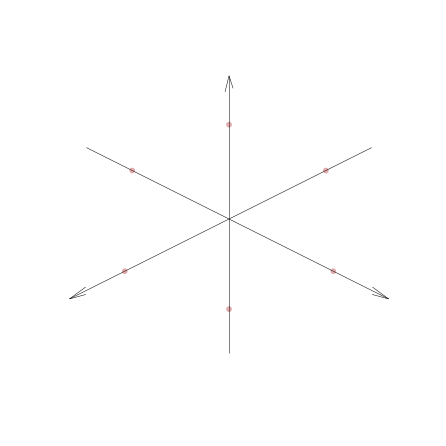

In [22]:
import matplotlib.pyplot as plt

X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
def convert_to_bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    return [ax, ay, az]
result_vectors = np.array([convert_to_bloch_vector(s) for s in result_states])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.grid(False)
ax.set_axis_off()
ax.view_init(30, 45)
ax.dist = 7
x, y, z = np.array([[-1.5, 0, 0], [0, -1.5, 0], [0, 0, -1.5]])
u, v, w = np.array([[3, 0, 0], [0, 3, 0], [0, 0, 3]])
ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.05, color="black", linewidth=0.5)
ax.scatter(result_vectors[:,0], result_vectors[:,1], result_vectors[:,2], c='#e29d9e', alpha=0.3)

The multi-qubit Clifford group can also be specified by only a small set
of generators (in fact, only one more than is needed for the
single-qubit case). Together, $H$, $S$, and CNOT (on every possible
qubit or pair of qubits) generate the $n$-qubit group. Be careful
though\-\--the size of the group increases exponentially. The 2-qubit
group alone has 11520 elements! The size can be worked out in a manner
analogous to that we used above in the single qubit case: by looking at
the combinatorics of the possible ways the gates can map Paulis with
only $X$ and $Z$ to other Paulis.

An experiment
=============

The whole idea of unitary designs may sound too good to be true. Can we
*really* compute the exact average fidelity using just 24 operations? In
this section, we put them to the test: we\'ll compute the average
fidelity of an operation first with experiments using a large but finite
amount of Haar-random unitaries, and then again with only the Clifford
group.

In [6]:
import pennylane as qml

# Scipy allows us to sample Haar-random unitaries directly
from scipy.stats import unitary_group

# set the random seed
np.random.seed(42)

# Use the mixed state simulator
dev = qml.device("default.mixed", wires=1)

Let\'s set up a noisy quantum channel. To keep things simple, assume it
consists of applying `~.pennylane.SX`{.interpreted-text role="class"},
the square-root of $X$ gate, followed by a few different types of noise.
First, write a quantum function for our ideal experiment:


In [7]:
def ideal_experiment():
    qml.SX(wires=0)
    return qml.state()

Next, we apply some noise. We do so by making use of a relatively new
feature in PennyLane called [quantum function
transforms](https://pennylane.readthedocs.io/en/latest/code/qml_transforms.html).
Such transforms work by modifying the underlying, low-level quantum
tapes which queue the quantum operations. Suppose the noisy channel is
composed of the following:


In [8]:
def noisy_operations(damp_factor, depo_factor, flip_prob):
    qml.AmplitudeDamping(damp_factor, wires=0)
    qml.DepolarizingChannel(depo_factor, wires=0)
    qml.BitFlip(flip_prob, wires=0)

Let\'s create a transform that applies this noise to any quantum
function *after* the original operations, but before the measurements.
We use the convenient
`~.pennylane.transforms.qfunc_transform`{.interpreted-text role="func"}
decorator:


In [9]:
@qml.qfunc_transform
def apply_noise(tape, damp_factor, depo_factor, flip_prob):
    # Apply the original operations
    for op in tape.operations:
        qml.apply(op)

    # Apply the noisy sequence
    noisy_operations(damp_factor, depo_factor, flip_prob)

    # Apply the original measurements
    for m in tape.measurements:
        qml.apply(m)

We can now apply this transform to create a noisy version of our ideal
quantum function:


In [10]:
# The strengths of various types of noise
damp_factor = 0.02
depo_factor = 0.02
flip_prob = 0.01

noisy_experiment = apply_noise(damp_factor, depo_factor, flip_prob)(ideal_experiment)

The last part of the experiment involves applying a random unitary
matrix before all the operations, and its inverse right before the
measurements. We can write another transform here to streamline this
process:


In [11]:
@qml.qfunc_transform
def conjugate_with_unitary(tape, matrix):
    qml.QubitUnitary(matrix, wires=0)

    for op in tape.operations:
        qml.apply(op)

    qml.QubitUnitary(matrix.conj().T, wires=0)

    for m in tape.measurements:
        qml.apply(m)

Finally, in order to perform a comparison, we need a function to compute
the [fidelity](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states)
compared to the ideal operation.


In [12]:
from scipy.linalg import sqrtm

def fidelity(rho, sigma):
    # Inputs rho and sigma are density matrices
    sqrt_sigma = sqrtm(sigma)
    fid = np.trace(sqrtm(sqrt_sigma @ rho @ sqrt_sigma))
    return fid.real

Let\'s now compute the average fidelity, averaging over 50000
Haar-random unitaries:


In [13]:
n_samples = 50000

fidelities = []

for _ in range(n_samples):
    # Select a Haar-random unitary
    U = unitary_group.rvs(2)

    # Apply transform to construct the ideal and noisy quantum functions
    conjugated_ideal_experiment = conjugate_with_unitary(U)(ideal_experiment)
    conjugated_noisy_experiment = conjugate_with_unitary(U)(noisy_experiment)

    # Use the functions to create QNodes
    ideal_qnode = qml.QNode(conjugated_ideal_experiment, dev)
    noisy_qnode = qml.QNode(conjugated_noisy_experiment, dev)

    # Execute the QNodes
    ideal_state = ideal_qnode()
    noisy_state = noisy_qnode()

    # Compute the fidelity
    fidelities.append(fidelity(ideal_state, noisy_state))

fid_mean = np.mean(fidelities)
print(f"Mean fidelity = {fid_mean}")

Mean fidelity = 0.9867904286122181


Now let\'s repeat the procedure using only Clifford group elements.
First, we write a quantum function that performs a Clifford operation
(or its inverse) based on its string representation.


In [14]:
def apply_single_clifford(clifford_string, inverse=False):
    for gate in clifford_string:
        if gate == 'H':
            qml.Hadamard(wires=0)
        else:
            sign = -1 if inverse else 1
            qml.PhaseShift(sign * np.pi/2, wires=0)

Next, we write a transform that applies a Clifford in the context of the
full experiment, i.e., apply the Clifford, then the operations, followed
by the inverse of the Clifford.


In [15]:
@qml.qfunc_transform
def conjugate_with_clifford(tape, clifford_string):
    apply_single_clifford(clifford_string, inverse=False)

    for op in tape.operations:
        qml.apply(op)

    apply_single_clifford(clifford_string, inverse=True)

    for m in tape.measurements:
        qml.apply(m)

You may have noticed this transform has exactly the same form as
`conjugate_with_unitary` from above. Only the input type has changed,
since the application of Cliffords here is specified by their string
representation.

It\'s now time to run the experiments:


In [16]:
fidelities = []

for C in single_qubit_cliffords:
    conjugated_ideal_experiment = conjugate_with_clifford(C)(ideal_experiment)
    conjugated_noisy_experiment = conjugate_with_clifford(C)(noisy_experiment)

    ideal_qnode = qml.QNode(conjugated_ideal_experiment, dev)
    noisy_qnode = qml.QNode(conjugated_noisy_experiment, dev)

    ideal_state = ideal_qnode()
    noisy_state = noisy_qnode()

    fidelities.append(fidelity(ideal_state, noisy_state))

Let\'s see how our results compare to the earlier simulation:


In [17]:
clifford_fid_mean = np.mean(fidelities)

print(f"Haar-random mean fidelity = {fid_mean}")
print(f"Clifford mean fidelity    = {clifford_fid_mean}")

Haar-random mean fidelity = 0.9867904286122181
Clifford mean fidelity    = 0.9867892187454865


Incredible 🤯 🤯 🤯 We were able to compute the average fidelity using only
24 experiments. Furthermore, the mean fidelity obtained from the
Clifford experiments is **exact**; even with 50000 Haar-random
experiments, we see deviations starting a few decimal places in.
Consider the resources that would be saved if you were actually
implementing this in a lab! It\'s not hard to see why the Clifford group
plays such an important role in characterization procedures.

Conclusion
==========

In this demo, we\'ve barely scratched the surface of designs and their
applications in quantum computing. While benchmarking is a key
application area, there are many others. The Pauli group as a unitary
1-design has applications in the construction of private quantum
channels[^1]. *Approximate* unitary $t$-designs (where the equality in
the definition is replaced by approximately equal up to some finite
precision) are also of interest, as there ways to construct them that
are more efficient than those of exact designs[^2]. In particular, it
has been shown that approximate complex projective 4-designs have
applications to the state discrimination problem[^3].

Furthermore, unitary designs are not the only designs that you\'ll
encounter in quantum computing. The familiar Hadamard gate is just a
2-dimensional example of a broader family of *Hadamard designs*, on
which there has been extensive research[^4]. Some sets of [mutually
orthogonal Latin
squares](https://en.wikipedia.org/wiki/Mutually_orthogonal_Latin_squares)
have a direct correspondence with mutually unbiased bases, which are
optimal quantum measurements[^5], as well as complex projective designs;
and Latin squares themselves have direct correspondence with affine and
projective planes, bringing us full circle back to the Fano plane from
which we began.

![An affine plane, Hadamard matrix, and a depiction of mutually
orthogonal Latin
squares.](/demonstrations/unitary_designs/affine-latin.svg){.align-center
width="80.0%"}

References
==========

[^1]: A. Ambainis, M. Mosca, A. Tapp, and R. de Wolf (2000) *Private
    Quantum Channels*. Proc. 41st FOCS, 547-553.
    [(PDF)](https://homepages.cwi.nl/~rdewolf/publ/qc/AMTW00.pdf).

[^2]: C. Dankert, R. Cleve, J. Emerson, and E. Levine (2009) *Exact and
    Approximate Unitary 2-Designs: Constructions and Applications.*
    Phys. Rev. A 80, 012304.
    [(arXiv)](https://arxiv.org/abs/quant-ph/0606161).

[^3]: A. Ambainis and J. Emerson (2007) *Quantum t-designs: t-wise
    independence in the quantum world.* Twenty-Second Annual IEEE
    Conference on Computational Complexity 129-140.
    [(arXiv)](https://arxiv.org/abs/quant-ph/0701126).

[^4]: J. Seberry and M. Yamada (1992) *Hadamard matrices, sequences, and
    block designs.* Contemporary Design Theory \-- A Collection of
    Surveys (D. J. Stinson and J. Dinitz, Eds.), John Wiley and Sons,
    431-560. [(PDF)](http://mathscinet.ru/files/YamadaSeberry1992.pdf).

[^5]: M. Gaeta, O. Di Matteo, A. B. Klimov, and H. de Guise (2014)
    *Discrete phase-space approach to mutually orthogonal Latin
    squares*. J. Phys. A: Math. Theor. 47 (43) 435303.
    [(arXiv)](https://arxiv.org/abs/1408.6742).
